In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from tqdm import tqdm

device = "cpu" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
#Loading model
import sys
import os
import torch
# Get the current script's directory
current_directory = os.getcwd()
print(current_directory)
library_directory = os.path.abspath(os.path.join(current_directory, 'torchVersion', 'BLIP'))
sys.path.append(library_directory)
from models.blip_vqa import blip_vqa

#model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_vqa.pth'

image_size = 640
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model = model.to(device)
print(model)

e:\10mociclo\FoundationModels\Multiple-choice-VQA\FineTuningBLIP
reshape position embedding from 900 to 1600
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_vqa.pth
BLIP_VQA(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=

**Dataset**

In [3]:
import sys
sys.path.append('../')  # Adjust the path accordingly
from VQA_Dataset_BLIP import VQA_Dataset_preloaded_TorchVersion

dataset = VQA_Dataset_preloaded_TorchVersion(device)
#dataset.compute_store(model.tokenizer, length=20, fileName="embeddingsBLIPWithMultipleChoiceImageSize640Length20_20_TorchVersion.h5")

In [4]:
dataset.load(fileName="embeddingsBLIPWithMultipleChoiceImageSize640Length20_20_TorchVersion.h5")

**Test-train split**

In [5]:
def custom_collate_fn(batch):
    # 'batch' is a list of samples, each being a dictionary
    return batch

In [6]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.7)
val_size = int(len(dataset)*0.2)
test_size = int(len(dataset))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

Train size:  14
Test size:  2


**Testing for one image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


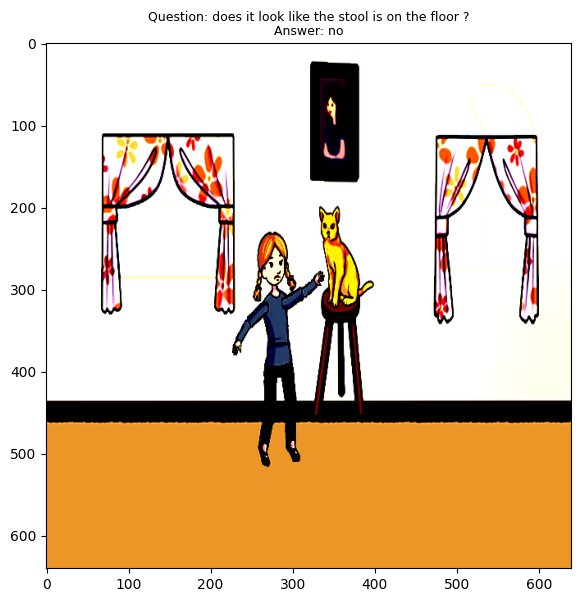

In [7]:
#Checking data
from utils import convert_ids_to_string
fig=plt.figure(0, (28, 15))
for element in val_dataloader:
    i=0
    ax = fig.add_subplot(2,int(batch_size/2),i+1)
    question_raw = element[i]["questions"]
    correct_answer_raw = element[i]["correct_answers"]
    multiple_answers = element[i]["multiple_answers"]
    question_text = convert_ids_to_string(question_raw["input_ids"], model)
    correct_answer_text = convert_ids_to_string(correct_answer_raw["input_ids"], model)
    img = element[i]["imgs"]
    ax.imshow(np.transpose(img.squeeze(0).cpu() , (1, 2, 0))) #Converting to matplotlib format
    ax.set_title("Question: "+question_text+"\nAnswer: "+correct_answer_text, fontsize=9)
    break

**Calculating grad and cams**

In [8]:
model.eval()

block_num = 0 #Number from 0 to 10
model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

loss = model(img, question_raw, answer = correct_answer_raw, train=False, inference='gradcam')
print(loss)
model.zero_grad()
loss.backward()

mask = correct_answer_raw["attention_mask"].view(correct_answer_raw["attention_mask"].size(0),1,-1,1,1)

grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()
print(cams.shape, grads.shape)

cams = cams[:, :, :, 1:].reshape(1, 12, -1, 40, 40) 
grads = grads[:, :, :, 1:].clamp(0).reshape(1, 12, -1, 40, 40)
print(cams.shape, grads.shape)

cams *= mask
grads *= mask

print(cams.shape, grads.shape)

gradcam = cams * grads
gradcam = gradcam[0].mean(0).cpu().detach()
print("gradcam shape: ", gradcam.shape)

tensor([4.1780], grad_fn=<SumBackward1>)
torch.Size([1, 12, 20, 1601]) torch.Size([1, 12, 20, 1601])
torch.Size([1, 12, 20, 40, 40]) torch.Size([1, 12, 20, 40, 40])
torch.Size([1, 12, 20, 40, 40]) torch.Size([1, 12, 20, 40, 40])
gradcam shape:  torch.Size([20, 40, 40])


**Predicting output**

In [20]:
idx = model(img, question_raw, answer = multiple_answers, train=False, inference='rank_compressed', k_test=18).item()
predicted_answer = multiple_answers["input_ids"][idx]
predicted_answer[0] = 30523
predicted_answer_text = convert_ids_to_string(predicted_answer.unsqueeze(0), model)

**Visualizing gradcam**

In [21]:
import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Gradcam\nPredicted answer: yes')

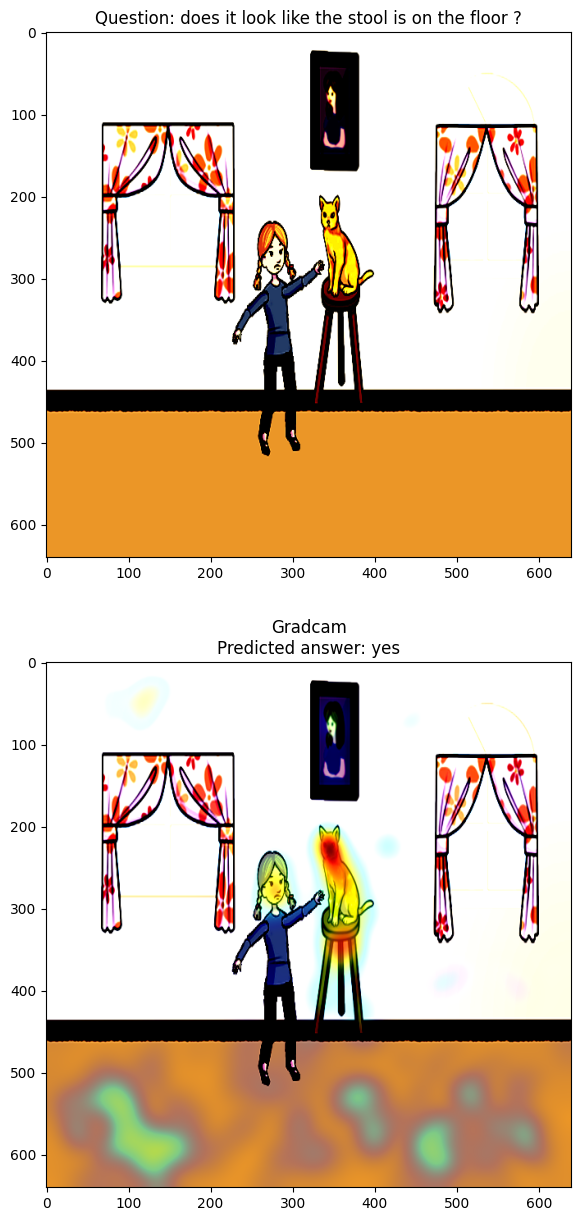

In [24]:
from PIL import Image

img_for_att = np.float32(np.transpose(img.squeeze(0).cpu() , (1, 2, 0)))

fig=plt.figure(0, (28, 15))
ax = fig.add_subplot(2,1,1)
img = element[i]["imgs"]
ax.imshow(img_for_att) #Converting to matplotlib format
ax.set_title("Question: "+str(question_text))

ax = fig.add_subplot(2,1,2)

gradcam_image = getAttMap(img_for_att, gradcam.mean(0))
ax.imshow(gradcam_image) #Converting to matplotlib format
ax.set_title("Gradcam\nPredicted answer: "+str(predicted_answer_text))